In [64]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [65]:
def load_pickle_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

In [66]:
train_data = load_pickle_data("Train_features.pkl")
val_data = load_pickle_data("Val_features.pkl")
test_data = load_pickle_data("Test_features.pkl")

# Pre-processing

In [67]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def extract_features_labels(data):
    X_list = []
    
    for item in data:
        # STFT: Lấy mean, variance, max
        stft_mean = np.array(item['stft_mean'])
        stft_var = np.array(item['stft_var'])
        stft_max = np.array(item['stft_max'])

        mfcc_mean = np.array(item['mfcc'])
        mfcc_delta2_mean = np.array(item['mfcc_delta2'])

        feature_vector = np.concatenate([stft_mean, stft_var, stft_max, mfcc_mean, mfcc_delta2_mean])
        X_list.append(feature_vector)

    y = np.array([item['category'] for item in data])

    # Xác định số lượng feature
    num_stft = stft_mean.shape[0]
    num_mfcc = mfcc_mean.shape[0]

    feature_columns = (
        [f"stft_mean_{i}" for i in range(num_stft)] +
        [f"stft_var_{i}" for i in range(num_stft)] +
        [f"stft_max_{i}" for i in range(num_stft)] +
        [f"mfcc_mean_{i}" for i in range(num_mfcc)] +
        [f"mfcc_delta2_mean_{i}" for i in range(num_mfcc)]
    )

    return pd.DataFrame(X_list, columns=feature_columns), y

X_train, y_train = extract_features_labels(train_data)
X_val, y_val = extract_features_labels(val_data)
X_test, y_test = extract_features_labels(test_data)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

print("✅ Feature extraction and scaling completed!")


✅ Feature extraction and scaling completed!


In [68]:
print(f"Số cột của X_train: {X_train.shape[1]}")

Số cột của X_train: 891


In [69]:
# Kiểm tra ma trận tương quan
corr_train = X_train_scaled.corr()
corr_val = X_val_scaled.corr()
corr_test = X_test_scaled.corr()

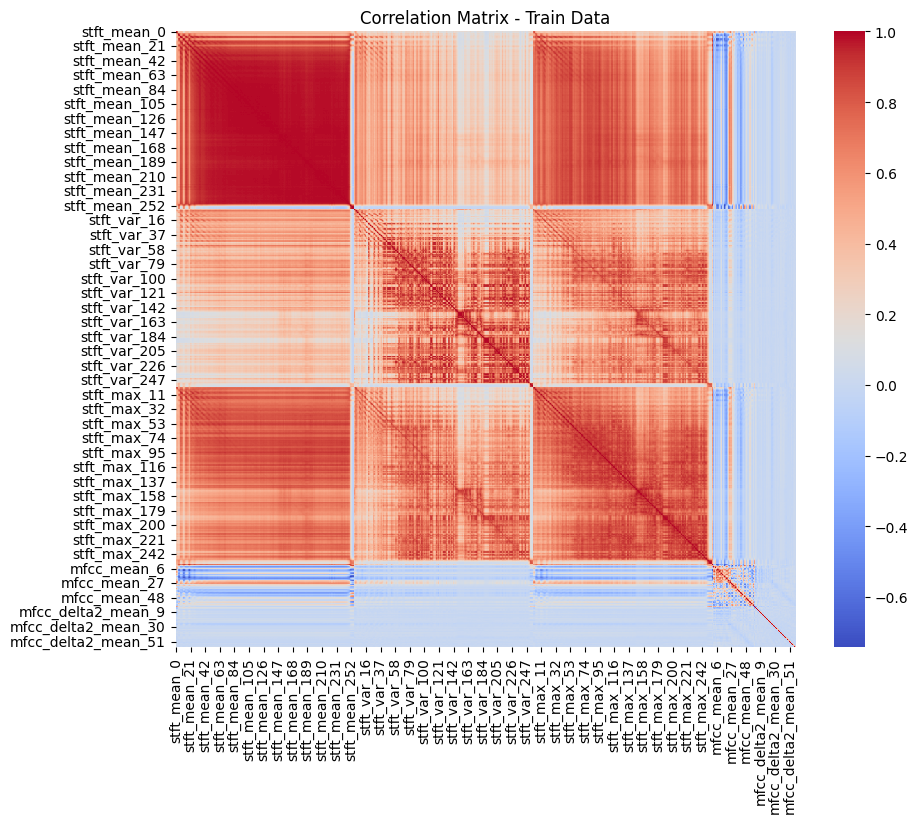

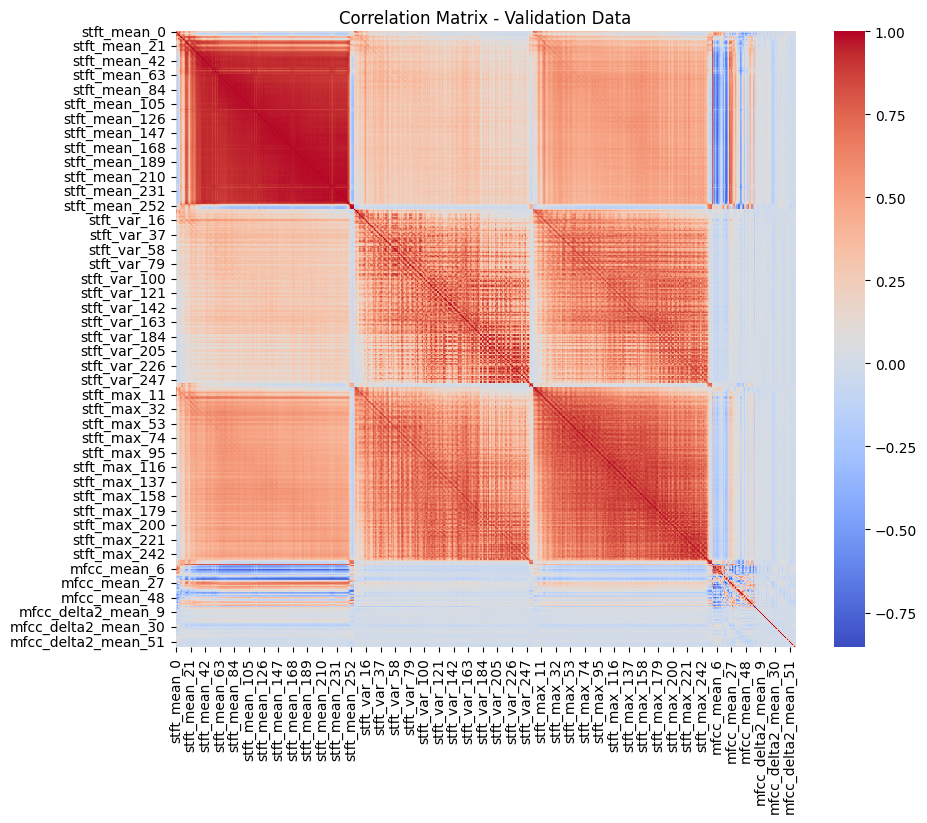

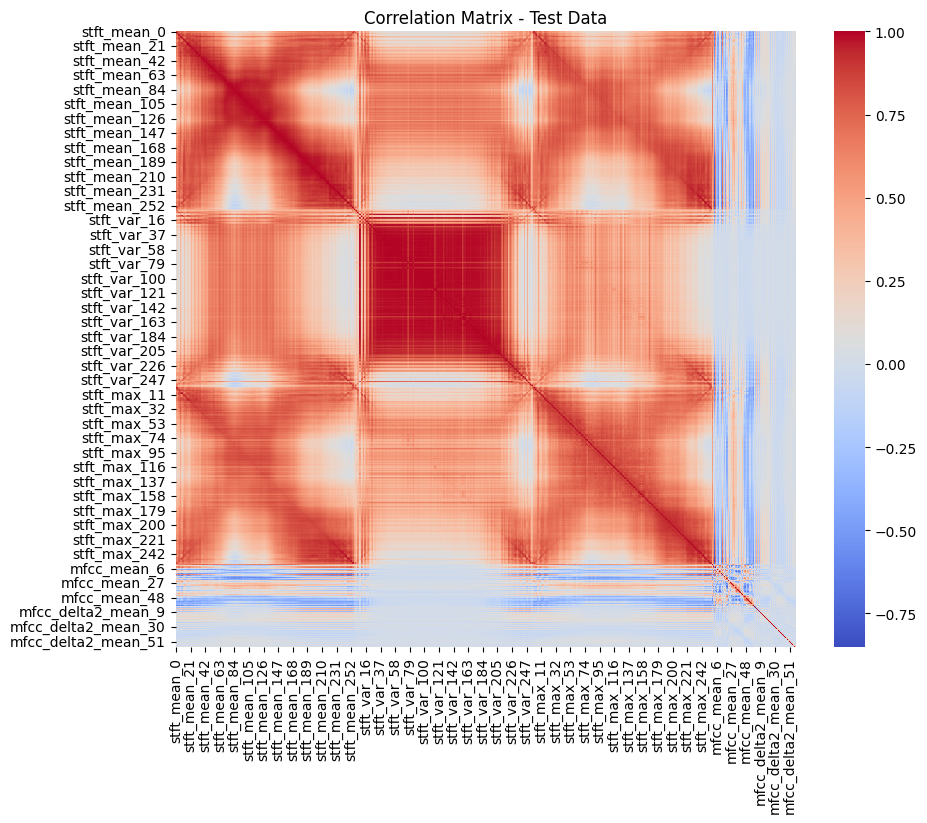

In [70]:
# Vẽ heatmap cho tập Train
plt.figure(figsize=(10, 8))
sns.heatmap(corr_train, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Correlation Matrix - Train Data")
plt.show()

# Vẽ heatmap cho tập Validation
plt.figure(figsize=(10, 8))
sns.heatmap(corr_val, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Correlation Matrix - Validation Data")
plt.show()

# Vẽ heatmap cho tập Test
plt.figure(figsize=(10, 8))
sns.heatmap(corr_test, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Correlation Matrix - Test Data")
plt.show()


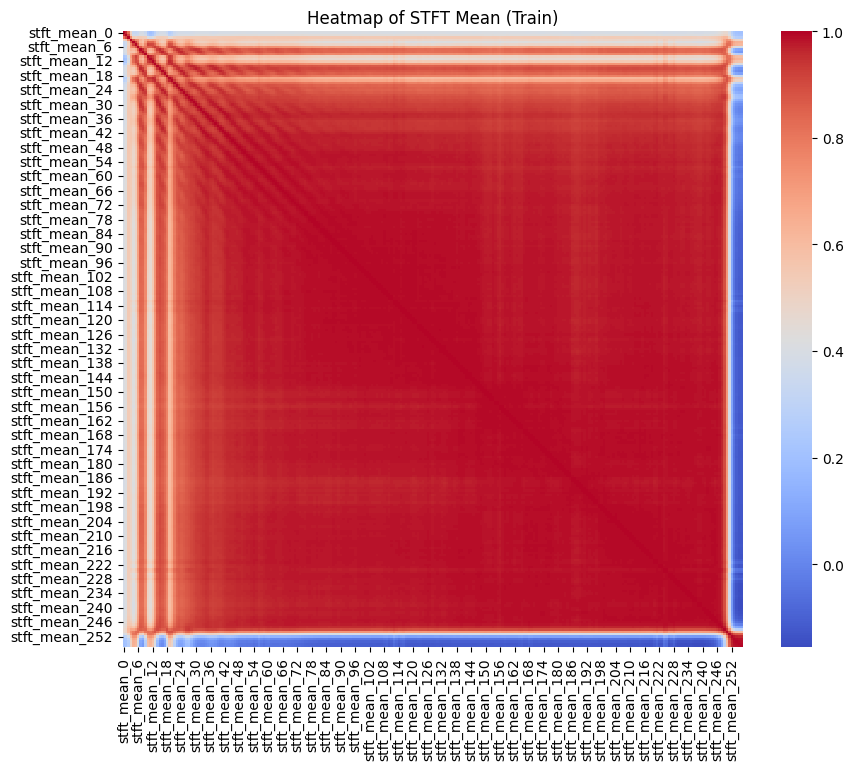

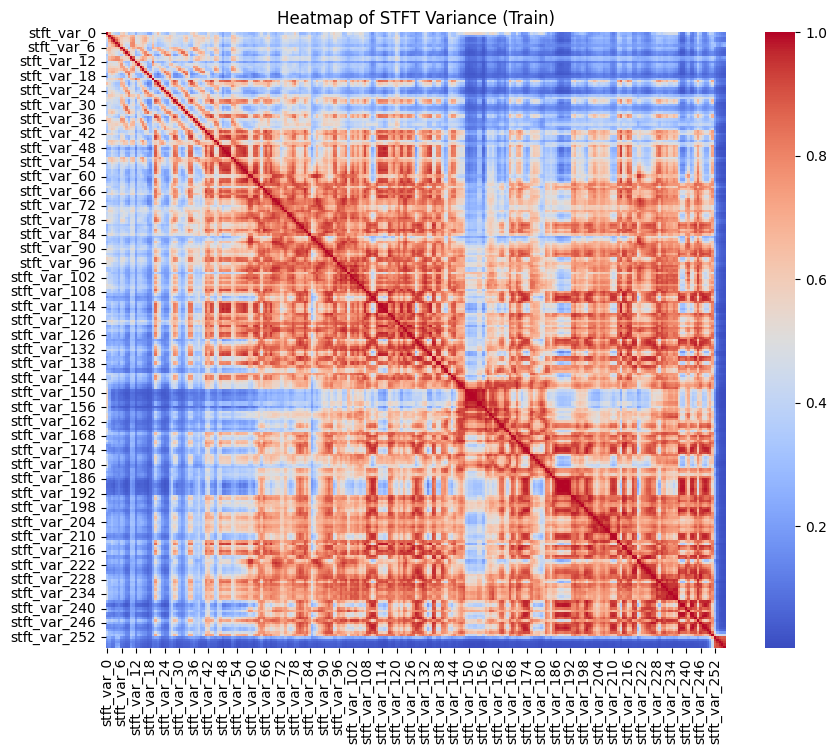

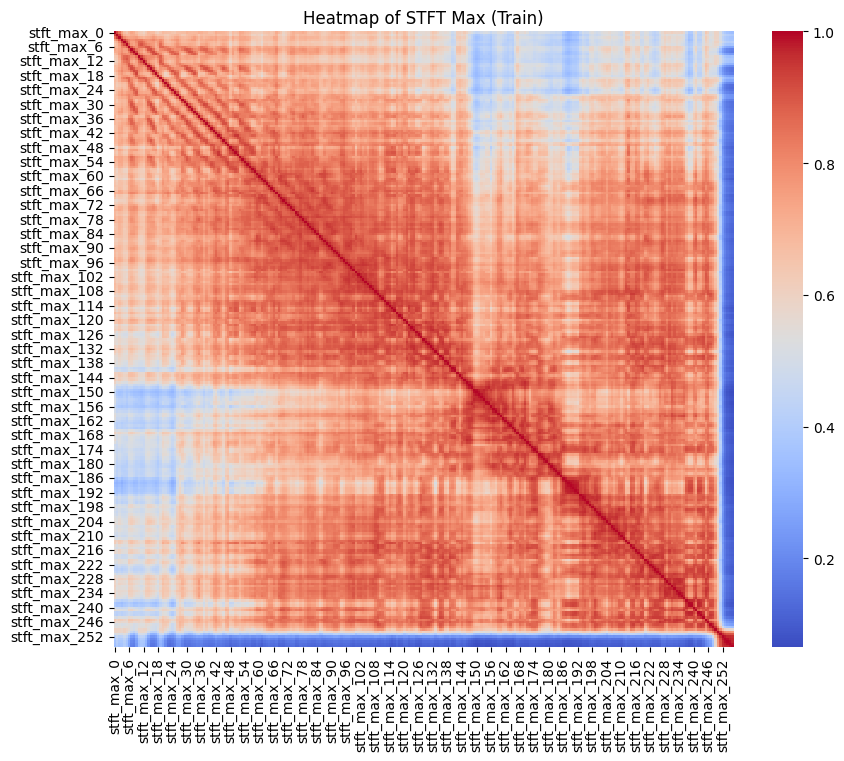

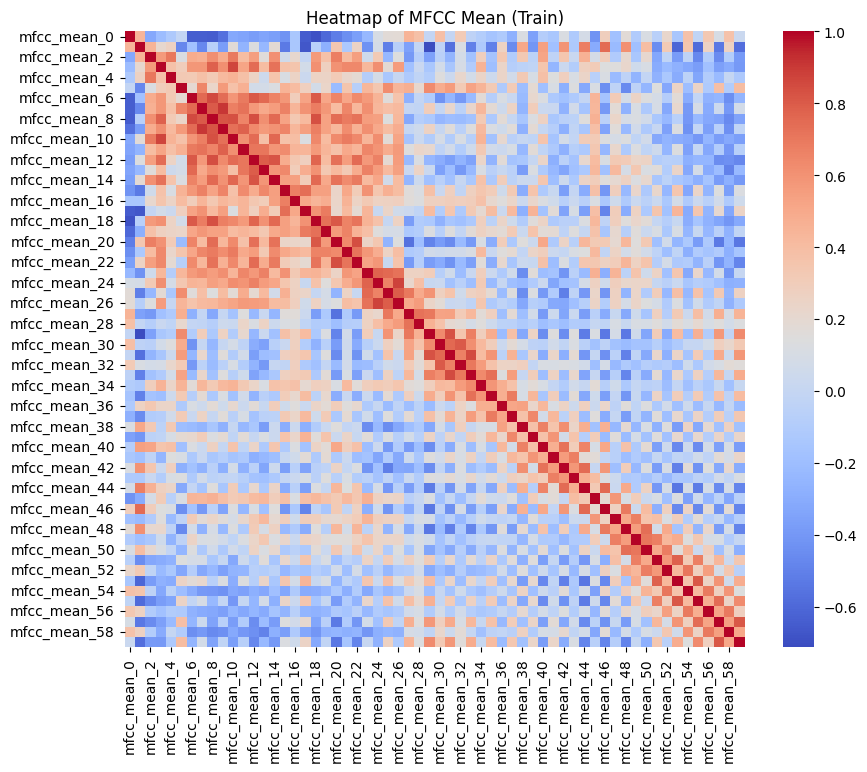

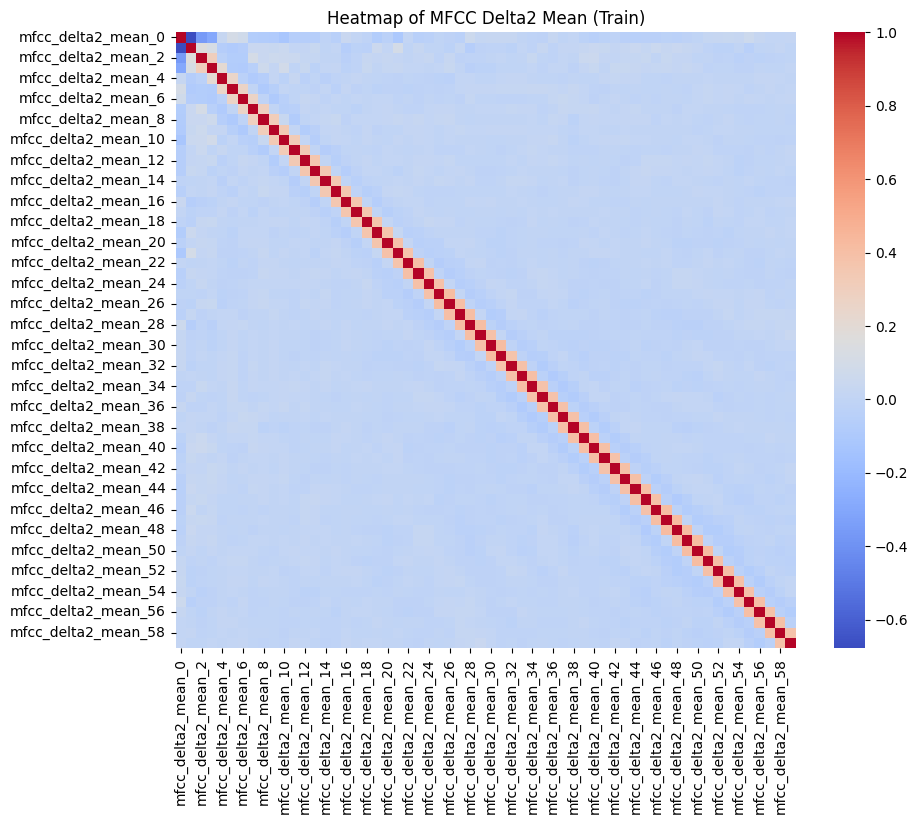

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# Xác định chỉ số cột
stft_mean_end = 257
stft_var_end = stft_mean_end + 257
stft_max_end = stft_var_end + 257
mfcc_mean_end = stft_max_end + 60
mfcc_delta2_end = mfcc_mean_end + 60

feature_groups = {
    "STFT Mean": (0, stft_mean_end),
    "STFT Variance": (stft_mean_end, stft_var_end),
    "STFT Max": (stft_var_end, stft_max_end),
    "MFCC Mean": (stft_max_end, mfcc_mean_end),
    "MFCC Delta2 Mean": (mfcc_mean_end, mfcc_delta2_end),
}

# Vẽ heatmap cho từng nhóm
for feature_name, (start, end) in feature_groups.items():
    plt.figure(figsize=(10, 8))
    sns.heatmap(X_train_scaled.iloc[:, start:end].corr(), cmap='coolwarm', annot=False, fmt=".2f")
    plt.title(f"Heatmap of {feature_name} (Train)")
    plt.show()


           Feature  Importance
224  stft_mean_224    0.060128
209  stft_mean_209    0.049485
212  stft_mean_212    0.040102
235  stft_mean_235    0.031291
228  stft_mean_228    0.030670
..             ...         ...
504   stft_var_247    0.000000
505   stft_var_248    0.000000
187  stft_mean_187    0.000000
172  stft_mean_172    0.000000
445   stft_var_188    0.000000

[891 rows x 2 columns]

Mean Importance: 0.001122
Max Importance: 0.060128
Median Importance: 0.000000


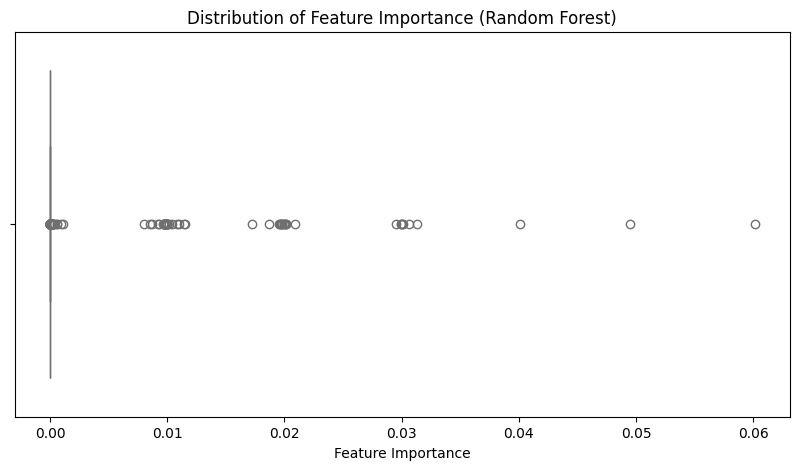

In [72]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Huấn luyện mô hình Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Lấy feature importance
feature_importances = rf.feature_importances_

# Chuyển thành DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': feature_importances
}).sort_values(by="Importance", ascending=False)

# In toàn bộ feature importance
print(feature_importance_df)

# Tính mean, max, median
importance_mean = feature_importance_df['Importance'].mean()
importance_max = feature_importance_df['Importance'].max()
importance_median = feature_importance_df['Importance'].median()

print(f"\nMean Importance: {importance_mean:.6f}")
print(f"Max Importance: {importance_max:.6f}")
print(f"Median Importance: {importance_median:.6f}")

# Vẽ Box Plot để xem phân bố
plt.figure(figsize=(10, 5))
sns.boxplot(x=feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Distribution of Feature Importance (Random Forest)")
plt.show()


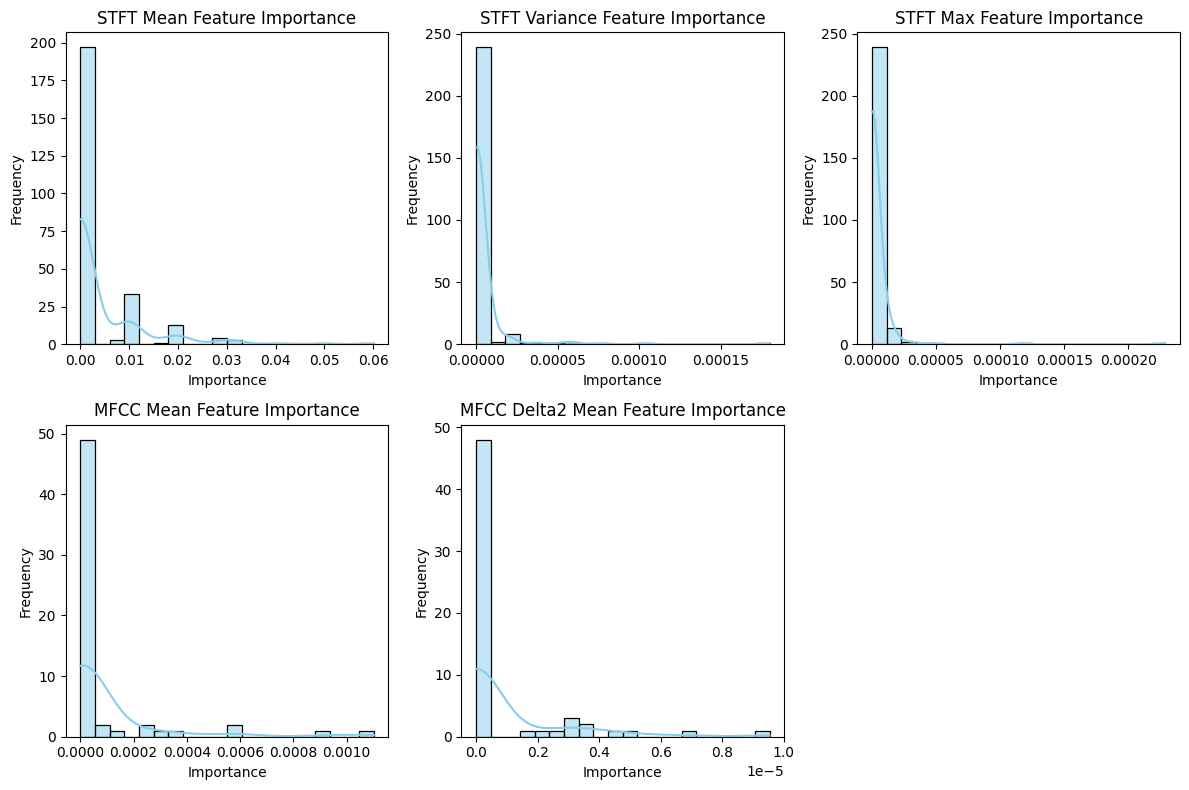

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tạo danh sách nhóm và từ khóa tương ứng
group_names = ["STFT Mean", "STFT Variance", "STFT Max", "MFCC Mean", "MFCC Delta2 Mean"]
group_filters = ["stft_mean", "stft_var", "stft_max", "mfcc_mean", "mfcc_delta2_mean"]

# Vẽ histogram cho từng nhóm
plt.figure(figsize=(12, 8))
for i, (group_name, filter_keyword) in enumerate(zip(group_names, group_filters), 1):
    group_df = feature_importance_df[feature_importance_df['Feature'].str.contains(filter_keyword, regex=False)]
    
    plt.subplot(2, 3, i)  # Chia thành 2 hàng, 3 cột
    sns.histplot(group_df['Importance'], bins=20, kde=True, color="skyblue")
    plt.title(f"{group_name} Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [74]:
zero_importance_features = feature_importance_df[feature_importance_df["Importance"] == 0]
num_zero_importance = len(zero_importance_features)

print(f"Số lượng feature có Importance = 0: {num_zero_importance}")
print(zero_importance_features)


Số lượng feature có Importance = 0: 580
           Feature  Importance
310    stft_var_53         0.0
700   stft_max_186         0.0
694   stft_max_180         0.0
695   stft_max_181         0.0
696   stft_max_182         0.0
..             ...         ...
504   stft_var_247         0.0
505   stft_var_248         0.0
187  stft_mean_187         0.0
172  stft_mean_172         0.0
445   stft_var_188         0.0

[580 rows x 2 columns]


In [75]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X_train_scaled, y_train, discrete_features=False)

mi_df = pd.DataFrame({
    "Feature": X_train_scaled.columns,
    "Mutual Information": mi_scores
}).sort_values(by="Mutual Information", ascending=False)

print(mi_df)


                 Feature  Mutual Information
15          stft_mean_15            0.693187
14          stft_mean_14            0.693187
22          stft_mean_22            0.693134
20          stft_mean_20            0.693111
27          stft_mean_27            0.693047
..                   ...                 ...
848  mfcc_delta2_mean_17            0.000000
861  mfcc_delta2_mean_30            0.000000
867  mfcc_delta2_mean_36            0.000000
866  mfcc_delta2_mean_35            0.000000
873  mfcc_delta2_mean_42            0.000000

[891 rows x 2 columns]


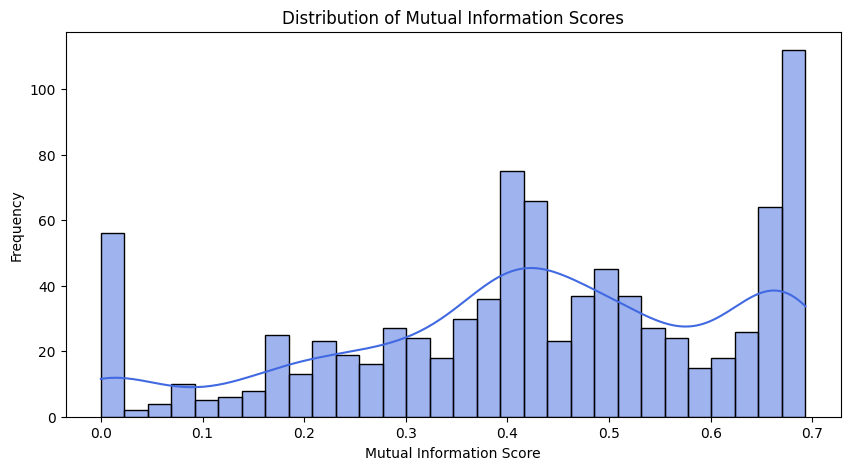

In [76]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns

mi_scores = mutual_info_classif(X_train_scaled, y_train, discrete_features=False)

# Tạo DataFrame kết quả
mi_df = pd.DataFrame({
    "Feature": X_train_scaled.columns,
    "Mutual Information": mi_scores
}).sort_values(by="Mutual Information", ascending=False)

# Vẽ biểu đồ histogram của MI scores
plt.figure(figsize=(10, 5))
sns.histplot(mi_df["Mutual Information"], bins=30, kde=True, color="royalblue")

# Thêm nhãn và tiêu đề
plt.xlabel("Mutual Information Score")
plt.ylabel("Frequency")
plt.title("Distribution of Mutual Information Scores")

# Hiển thị biểu đồ
plt.show()



In [77]:
# Sắp xếp MI theo giá trị giảm dần
mi_df_sorted = mi_df.sort_values(by="Mutual Information", ascending=False)

# In danh sách feature theo thứ tự MI giảm dần
for feature, score in zip(mi_df_sorted["Feature"], mi_df_sorted["Mutual Information"]):
    print(f"{feature}: {score:.6f}")


stft_mean_15: 0.693187
stft_mean_14: 0.693187
stft_mean_22: 0.693134
stft_mean_20: 0.693111
stft_mean_27: 0.693047
stft_mean_16: 0.693023
stft_mean_21: 0.692991
stft_mean_13: 0.692939
stft_mean_29: 0.692739
stft_mean_23: 0.692642
stft_mean_19: 0.692484
stft_mean_26: 0.692483
stft_mean_28: 0.692412
stft_var_14: 0.692158
stft_mean_10: 0.691767
stft_var_15: 0.691754
stft_mean_30: 0.691570
stft_mean_17: 0.691560
stft_mean_18: 0.691316
stft_mean_12: 0.691113
stft_mean_31: 0.690906
stft_mean_9: 0.690251
stft_mean_25: 0.690077
stft_mean_24: 0.690046
stft_var_13: 0.689883
stft_mean_32: 0.689746
stft_max_15: 0.689438
stft_max_14: 0.689434
stft_var_16: 0.689254
stft_var_11: 0.689086
stft_var_10: 0.688185
stft_var_6: 0.688110
stft_var_20: 0.687634
stft_var_21: 0.687617
stft_var_22: 0.687482
stft_mean_228: 0.687214
stft_var_9: 0.687033
stft_mean_218: 0.686991
stft_mean_11: 0.686973
stft_var_7: 0.686584
stft_mean_224: 0.686561
stft_mean_215: 0.686466
stft_max_13: 0.686401
stft_mean_225: 0.686397
st

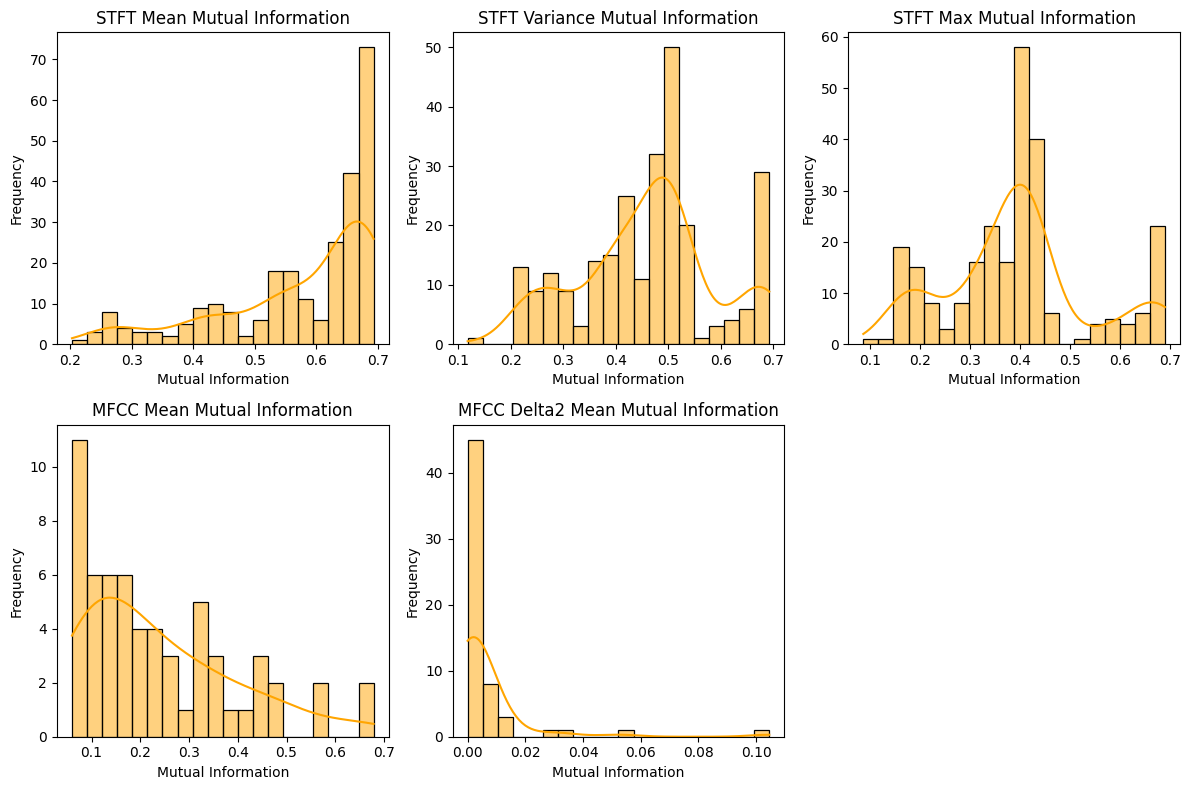

In [78]:
plt.figure(figsize=(12, 8))
for i, (group_name, filter_keyword) in enumerate(zip(group_names, group_filters), 1):
    group_df = mi_df[mi_df['Feature'].str.contains(filter_keyword, regex=False)]
    
    plt.subplot(2, 3, i)  # Chia thành 2 hàng, 3 cột
    sns.histplot(group_df['Mutual Information'], bins=20, kde=True, color="orange")
    plt.title(f"{group_name} Mutual Information")
    plt.xlabel("Mutual Information")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


# MFCC (Processing)

In [79]:
selected_features = [col for col in X_train_scaled.columns if "mfcc_mean_" in col or "mfcc_delta2_mean_" in col]

X_train_selected = X_train_scaled[selected_features]
X_val_selected = X_val_scaled[selected_features]
X_test_selected = X_test_scaled[selected_features]

print(f"Số lượng feature sau khi chọn: {X_train_selected.shape[1]}")


Số lượng feature sau khi chọn: 120


In [80]:
from sklearn.ensemble import RandomForestClassifier  # hoặc RandomForestRegressor
import numpy as np
import pandas as pd

# Huấn luyện mô hình để lấy importance score
model = RandomForestClassifier(random_state=42)  # Chỉnh theo bài toán của bạn
model.fit(X_train_selected, y_train)

# Lưu importance score vào DataFrame
feature_importance_df = pd.DataFrame({
    "Feature": X_train_selected.columns,
    "Importance": model.feature_importances_
})

# Tính giá trị trung bình của importance
mean_importance = feature_importance_df["Importance"].mean()

# Lọc các cột có importance < mean
low_importance_features = feature_importance_df[feature_importance_df["Importance"] < mean_importance]["Feature"].values

# Các cột còn lại giữ nguyên
high_importance_features = feature_importance_df[feature_importance_df["Importance"] >= mean_importance]["Feature"].values

X_train_high = X_train_selected[high_importance_features]
X_val_high = X_val_selected[high_importance_features]
X_test_high = X_test_selected[high_importance_features]


In [81]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Chuẩn hóa dữ liệu trước khi PCA
scaler = StandardScaler()
X_train_low_scaled = scaler.fit_transform(X_train_selected[low_importance_features])
X_val_low_scaled = scaler.transform(X_val_selected[low_importance_features])
X_test_low_scaled = scaler.transform(X_test_selected[low_importance_features])

# Áp dụng PCA với 5 thành phần
pca = PCA(n_components=5, random_state=42)
X_train_pca = pca.fit_transform(X_train_low_scaled)
X_val_pca = pca.transform(X_val_low_scaled)
X_test_pca = pca.transform(X_test_low_scaled)

# Chuyển thành DataFrame
pca_columns = [f"PCA_{i+1}" for i in range(5)]
X_train_pca_df = pd.DataFrame(X_train_pca, columns=pca_columns)
X_val_pca_df = pd.DataFrame(X_val_pca, columns=pca_columns)
X_test_pca_df = pd.DataFrame(X_test_pca, columns=pca_columns)


In [82]:
num_zero_importance = (feature_importance_df["Importance"] == 0).sum()
print(f"Số lượng feature ban đầu: {X_train_selected.shape[1]}")
print(f"Số lượng feature có importance >= mean: {len(high_importance_features)}")
print(f"Số lượng feature có importance = 0: {num_zero_importance}")


Số lượng feature ban đầu: 120
Số lượng feature có importance >= mean: 23
Số lượng feature có importance = 0: 0


In [83]:
X_train_final = pd.concat([X_train_high.reset_index(drop=True), X_train_pca_df], axis=1)
X_val_final = pd.concat([X_val_high.reset_index(drop=True), X_val_pca_df], axis=1)
X_test_final = pd.concat([X_test_high.reset_index(drop=True), X_test_pca_df], axis=1)

print(f"Số lượng feature ban đầu: {X_train_selected.shape[1]}")
print(f"Số lượng feature sau khi PCA: {X_train_final.shape[1]}")


Số lượng feature ban đầu: 120
Số lượng feature sau khi PCA: 28


In [84]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Chuẩn hóa dữ liệu trước khi PCA
scaler = StandardScaler()
X_train_low_scaled = scaler.fit_transform(X_train_selected[low_importance_features])
X_val_low_scaled = scaler.transform(X_val_selected[low_importance_features])
X_test_low_scaled = scaler.transform(X_test_selected[low_importance_features])

# Áp dụng PCA với 5 thành phần
pca = PCA(n_components=5, random_state=42)
X_train_pca = pca.fit_transform(X_train_low_scaled)
X_val_pca = pca.transform(X_val_low_scaled)
X_test_pca = pca.transform(X_test_low_scaled)

# Chuyển thành DataFrame
pca_columns = [f"PCA_{i+1}" for i in range(5)]
X_train_pca_df = pd.DataFrame(X_train_pca, columns=pca_columns)
X_val_pca_df = pd.DataFrame(X_val_pca, columns=pca_columns)
X_test_pca_df = pd.DataFrame(X_test_pca, columns=pca_columns)

num_zero_importance = (feature_importance_df["Importance"] == 0).sum()
print(f"Số lượng feature ban đầu: {X_train_selected.shape[1]}")
print(f"Số lượng feature có importance >= mean: {len(high_importance_features)}")
print(f"Số lượng feature có importance = 0: {num_zero_importance}")

X_train_final = pd.concat([X_train_high.reset_index(drop=True), X_train_pca_df], axis=1)
X_val_final = pd.concat([X_val_high.reset_index(drop=True), X_val_pca_df], axis=1)
X_test_final = pd.concat([X_test_high.reset_index(drop=True), X_test_pca_df], axis=1)

print(f"Số lượng feature ban đầu: {X_train_selected.shape[1]}")
print(f"Số lượng feature sau khi PCA: {X_train_final.shape[1]}")

Số lượng feature ban đầu: 120
Số lượng feature có importance >= mean: 23
Số lượng feature có importance = 0: 0
Số lượng feature ban đầu: 120
Số lượng feature sau khi PCA: 28


In [85]:
print(f"Số lượng feature sau khi PCA: {X_val_final.shape[1]}")
print(f"Số lượng feature sau khi PCA: {X_test_final.shape[1]}")

Số lượng feature sau khi PCA: 28
Số lượng feature sau khi PCA: 28


In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

# Kiểm tra số lượng feature
print(f"Số lượng feature ban đầu: {X_train_high.shape[1]}")
print(f"Số lượng feature sau PCA: {X_train_final.shape[1]}")

# Định nghĩa tham số GridSearch
param_grid = {
    'criterion' :['gini', 'entropy', 'log_loss'],
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Chạy GridSearch trên tập validation
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_val_final, y_val)

best_params = grid_search.best_params_
print("\nBest Parameters:", best_params)

# Huấn luyện mô hình với tham số tối ưu
rf_final = RandomForestClassifier(**best_params, random_state=42)
rf_final.fit(X_train_final, y_train)

# Dự đoán trên tập validation & test
y_val_pred = rf_final.predict(X_val_final)
y_test_pred = rf_final.predict(X_test_final)

# Đánh giá mô hình
def evaluate_model(y_true, y_pred, name):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    print(f"{name} - Accuracy: {acc:.4f}, F1-score: {f1:.4f}")

evaluate_model(y_val, y_val_pred, "RF Hybrid (Validation)")
evaluate_model(y_test, y_test_pred, "RF Hybrid (Test)")


Số lượng feature ban đầu: 23
Số lượng feature sau PCA: 28

Best Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
RF Hybrid (Validation) - Accuracy: 0.9642, F1-score: 0.9641
RF Hybrid (Test) - Accuracy: 0.9936, F1-score: 0.9936


In [87]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Chọn các cột 'stft_*' từ X_train_scaled
stft_columns = [col for col in X_train_scaled.columns if col.startswith("stft_")]

# Lấy dữ liệu STFT từ X_train_scaled
X_stft = X_train_scaled[stft_columns]
X_val_stft = X_val_scaled[stft_columns]
X_test_stft = X_test_scaled[stft_columns]
# 1️⃣ Tính ma trận tương quan
correlation_matrix = X_stft.corr().abs()

# 2️⃣ Tìm các cặp có tương quan cao (> 0.99)
high_corr_pairs = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if correlation_matrix.iloc[i, j] > 0.99:
            col1 = correlation_matrix.columns[i]
            col2 = correlation_matrix.columns[j]
            high_corr_pairs.add((col1, col2))

# 3️⃣ Dùng RandomForest để tìm feature importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X_stft, y_train)
feature_importances = pd.Series(rf.feature_importances_, index=X_stft.columns)

# 4️⃣ Xóa cột có feature importance cao hơn trong mỗi cặp
columns_to_drop = set()
for col1, col2 in high_corr_pairs:
    if feature_importances[col1] > feature_importances[col2]:
        columns_to_drop.add(col1)
    else:
        columns_to_drop.add(col2)

# 5️⃣ Xóa các cột đã chọn
X_stft_filtered = X_stft.drop(columns=columns_to_drop)
print(f"Đã loại bỏ {len(columns_to_drop)} cột có tương quan cao.")

# 6️⃣ Chuẩn hóa dữ liệu sau khi lọc
scaler = StandardScaler()
X_stft_scaled = scaler.fit_transform(X_stft_filtered)

# 7️⃣ Tìm số thành phần PCA tối ưu bằng Cross-Validation
best_score = -np.inf
best_n_components = None

for n_components in range(1, 10):
    pca = PCA(n_components=n_components, random_state=42)
    X_stft_pca = pca.fit_transform(X_stft_scaled)
    
    model = RandomForestClassifier(random_state=42)
    scores = cross_val_score(model, X_stft_pca, y_train, cv=5, scoring='accuracy')
    
    mean_score = np.mean(scores)
    
    if mean_score > best_score:
        best_score = mean_score
        best_n_components = n_components

print(f"Số thành phần PCA tối ưu: {best_n_components}, Score: {best_score:.4f}")

pca = PCA(n_components=best_n_components, random_state=42)
X_stft_pca = pca.fit_transform(X_stft_scaled)

stft_pca_columns = [f"stft_PCA_{i+1}" for i in range(best_n_components)]
X_stft_pca_df = pd.DataFrame(X_stft_pca, columns=stft_pca_columns)

X_train_final = pd.concat([X_train_final.reset_index(drop=True), X_stft_pca_df], axis=1)

print(f"Số lượng feature sau khi thêm STFT PCA: {X_train_final.shape[1]}")

X_val_stft_filtered = X_val_stft.drop(columns=columns_to_drop_val)
X_test_stft_filtered = X_test_stft.drop(columns=columns_to_drop_test)

X_val_stft_scaled = scaler.transform(X_val_stft_filtered)
X_test_stft_scaled = scaler.transform(X_test_stft_filtered)

X_val_stft_pca = pca.transform(X_val_stft_scaled)
X_test_stft_pca = pca.transform(X_test_stft_scaled)

X_val_stft_pca_df = pd.DataFrame(X_val_stft_pca, columns=stft_pca_columns)
X_test_stft_pca_df = pd.DataFrame(X_test_stft_pca, columns=stft_pca_columns)

X_val_final = pd.concat([X_val_final.reset_index(drop=True), X_val_stft_pca_df], axis=1)
X_test_final = pd.concat([X_test_final.reset_index(drop=True), X_test_stft_pca_df], axis=1)

# Kiểm tra số lượng cột sau khi thêm PCA
print(f"Số lượng feature sau khi thêm STFT PCA vào X_val_final: {X_val_final.shape[1]}")
print(f"Số lượng feature sau khi thêm STFT PCA vào X_test_final: {X_test_final.shape[1]}")


Đã loại bỏ 223 cột có tương quan cao.
Số thành phần PCA tối ưu: 9, Score: 0.9989
Số lượng feature sau khi thêm STFT PCA: 37
Số lượng feature sau khi thêm STFT PCA vào X_val_final: 37
Số lượng feature sau khi thêm STFT PCA vào X_test_final: 37


Best PCA STFT: 9

# PCA STFT

In [88]:
print(f"Số lượng feature sau khi PCA: {X_val_final.shape[1]}")
print(f"Số lượng feature sau khi PCA: {X_test_final.shape[1]}")

Số lượng feature sau khi PCA: 37
Số lượng feature sau khi PCA: 37


In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Định nghĩa tập tham số cần tìm kiếm
param_grid = {
    'criterion' :['gini', 'entropy', 'log_loss'],
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Khởi tạo mô hình Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Khởi tạo GridSearchCV với 5-fold cross-validation
grid_search = GridSearchCV(
    rf_model, param_grid, cv=5, scoring='accuracy', verbose=1
)

# Chạy Grid Search trên tập huấn luyện
grid_search.fit(X_train_final, y_train)

# Lấy tham số tốt nhất
best_params = grid_search.best_params_
print(f"🔍 Best parameters: {best_params}")

# Huấn luyện mô hình với tham số tối ưu
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train_final, y_train)

# Dự đoán trên tập validation và test
y_val_pred = best_model.predict(X_val_final)
y_test_pred = best_model.predict(X_test_final)

# Đánh giá mô hình trên tập validation
print("\n📊 Đánh giá trên tập validation:")
print(classification_report(y_val, y_val_pred))

# Đánh giá mô hình trên tập test
print("\n📊 Đánh giá trên tập test:")
print(classification_report(y_test, y_test_pred))

# In accuracy trên validation và test
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\n✅ Accuracy trên tập validation: {val_accuracy:.4f}")
print(f"✅ Accuracy trên tập test: {test_accuracy:.4f}")


Fitting 5 folds for each of 144 candidates, totalling 720 fits
🔍 Best parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}

📊 Đánh giá trên tập validation:
               precision    recall  f1-score   support

None_swarming       0.92      0.98      0.95      1800
     Swarming       0.98      0.91      0.94      1800

     accuracy                           0.95      3600
    macro avg       0.95      0.95      0.95      3600
 weighted avg       0.95      0.95      0.95      3600


📊 Đánh giá trên tập test:
               precision    recall  f1-score   support

None_swarming       1.00      0.98      0.99      2400
     Swarming       0.98      1.00      0.99      2441

     accuracy                           0.99      4841
    macro avg       0.99      0.99      0.99      4841
 weighted avg       0.99      0.99      0.99      4841


✅ Accuracy trên tập validation: 0.9453
✅ Accuracy trên tập test: 0.9907


Best parameter (CV)

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, classification_report

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

best_val_accuracy = 0
best_params = None
best_model = None

for params in ParameterGrid(param_grid):
    model = RandomForestClassifier(**params, random_state=42)
    model.fit(X_train_final, y_train)

    y_val_pred = model.predict(X_val_final)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_params = params
        best_model = model

print(f"🔍 Best parameters (based on validation): {best_params}")

y_val_pred = best_model.predict(X_val_final)
val_accuracy = accuracy_score(y_val, y_val_pred)
print("\n📊 Đánh giá trên tập validation:")
print(classification_report(y_val, y_val_pred))
print(f"✅ Accuracy trên tập validation: {val_accuracy:.4f}")

y_test_pred = best_model.predict(X_test_final)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("\n📊 Đánh giá trên tập test:")
print(classification_report(y_test, y_test_pred))
print(f"✅ Accuracy trên tập test: {test_accuracy:.4f}")


🔍 Best parameters (based on validation): {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 150}

📊 Đánh giá trên tập validation:
               precision    recall  f1-score   support

None_swarming       0.93      0.98      0.95      1800
     Swarming       0.98      0.93      0.95      1800

     accuracy                           0.95      3600
    macro avg       0.95      0.95      0.95      3600
 weighted avg       0.95      0.95      0.95      3600

✅ Accuracy trên tập validation: 0.9536

📊 Đánh giá trên tập test:
               precision    recall  f1-score   support

None_swarming       1.00      0.94      0.97      2400
     Swarming       0.95      1.00      0.97      2441

     accuracy                           0.97      4841
    macro avg       0.97      0.97      0.97      4841
 weighted avg       0.97      0.97      0.97      4841

✅ Accuracy trên tập test: 0.9727


Best parameter (val)

In [91]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Danh sách các mô hình và tham số cần tìm kiếm
models_params = {
    "SVM": {
        "model": SVC(),
        "params": {
            "C": [0.001, 0.01, 0.1, 1, 10],
            "kernel": ["linear", "rbf"],
            "gamma": ["scale", "auto"]
        }
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7, 9],
            "weights": ["uniform", "distance"],
            "metric": ["euclidean", "manhattan"]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "n_estimators": [10, 20, 30, 40, 50, 100, 150],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 7]
        }
    },
    "Naive Bayes": {
        "model": GaussianNB(),
        "params": {} 
    }
}

# Lưu kết quả
results = []

for model_name, model_info in models_params.items():
    print(f"\n🔍 Đang tìm tham số tốt nhất cho {model_name}...")

    # Nếu mô hình có tham số cần tìm kiếm
    if model_info["params"]:
        grid_search = GridSearchCV(
            model_info["model"], model_info["params"],
            cv=5, scoring='accuracy', n_jobs=-1, verbose=1
        )
        grid_search.fit(X_train_final, y_train)
        best_params = grid_search.best_params_
        best_model = grid_search.best_estimator_
        print(f"✅ {model_name} - Best Params: {best_params}")
    else:
        # Nếu không có tham số cần tối ưu (Naive Bayes)
        best_model = model_info["model"]
        best_model.fit(X_train_final, y_train)
        best_params = "Default"

    # Dự đoán
    y_val_pred = best_model.predict(X_val_final)
    y_test_pred = best_model.predict(X_test_final)

    # Đánh giá mô hình
    val_acc = accuracy_score(y_val, y_val_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    print(f"\n📊 Đánh giá {model_name} trên tập validation:")
    print(classification_report(y_val, y_val_pred))

    print(f"\n📊 Đánh giá {model_name} trên tập test:")
    print(classification_report(y_test, y_test_pred))

    print(f"✅ Accuracy trên tập validation: {val_acc:.4f}")
    print(f"✅ Accuracy trên tập test: {test_acc:.4f}")

    # Lưu vào danh sách kết quả
    results.append([model_name, best_params, val_acc, test_acc])

# In bảng tổng hợp kết quả
results_df = pd.DataFrame(results, columns=["Model", "Best Params", "Validation Accuracy", "Test Accuracy"])
print("\n📌 Tổng hợp kết quả:")
print(results_df)



🔍 Đang tìm tham số tốt nhất cho SVM...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ SVM - Best Params: {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}

📊 Đánh giá SVM trên tập validation:
               precision    recall  f1-score   support

None_swarming       1.00      0.71      0.83      1800
     Swarming       0.78      1.00      0.87      1800

     accuracy                           0.85      3600
    macro avg       0.89      0.85      0.85      3600
 weighted avg       0.89      0.85      0.85      3600


📊 Đánh giá SVM trên tập test:
               precision    recall  f1-score   support

None_swarming       1.00      0.99      0.99      2400
     Swarming       0.99      1.00      0.99      2441

     accuracy                           0.99      4841
    macro avg       0.99      0.99      0.99      4841
 weighted avg       0.99      0.99      0.99      4841

✅ Accuracy trên tập validation: 0.8550
✅ Accuracy trên tập test: 0.9940

🔍 Đang tìm tham số t

In [92]:
print(results_df[results_df["Model"] == "KNN"]["Best Params"].values[0])


{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}


# Soft Voting

In [93]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

best_models = [
    ("SVM", SVC(C=0.1, gamma="scale", kernel="linear", probability=True)),
    ("KNN", KNeighborsClassifier(n_neighbors=3, weights="uniform", metric="euclidean")),
    ("Gradient Boosting", GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)),
    ("Random Forest", RandomForestClassifier(
        n_estimators=100, criterion="gini", max_depth=None, min_samples_split=2, random_state=42
    )),
    ("Extra Trees", ExtraTreesClassifier(
        criterion="gini", max_depth=None, min_samples_split=2, n_estimators=30, random_state=42
    ))
]

soft_voting_clf = VotingClassifier(estimators=best_models, voting='soft', n_jobs=-1)
soft_voting_clf.fit(X_train_final, y_train)

# Dự đoán
y_val_pred = soft_voting_clf.predict(X_val_final)
y_test_pred = soft_voting_clf.predict(X_test_final)

# Đánh giá
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\n📊 Đánh giá Soft Voting trên tập validation:")
print(classification_report(y_val, y_val_pred))

print("\n📊 Đánh giá Soft Voting trên tập test:")
print(classification_report(y_test, y_test_pred))

print(f"✅ Accuracy trên tập validation: {val_acc:.4f}")
print(f"✅ Accuracy trên tập test: {test_acc:.4f}")



📊 Đánh giá Soft Voting trên tập validation:
               precision    recall  f1-score   support

None_swarming       0.99      0.96      0.97      1800
     Swarming       0.96      0.99      0.97      1800

     accuracy                           0.97      3600
    macro avg       0.97      0.97      0.97      3600
 weighted avg       0.97      0.97      0.97      3600


📊 Đánh giá Soft Voting trên tập test:
               precision    recall  f1-score   support

None_swarming       1.00      0.98      0.99      2400
     Swarming       0.98      1.00      0.99      2441

     accuracy                           0.99      4841
    macro avg       0.99      0.99      0.99      4841
 weighted avg       0.99      0.99      0.99      4841

✅ Accuracy trên tập validation: 0.9731
✅ Accuracy trên tập test: 0.9893


# Hard Voting

In [94]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

best_models = [
    ("SVM", SVC(C=0.1, gamma="scale", kernel="linear", probability=True)),
    ("KNN", KNeighborsClassifier(n_neighbors=3, weights="uniform", metric="euclidean")),
    ("Gradient Boosting", GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)),
    ("Random Forest", RandomForestClassifier(
        n_estimators=100, criterion="gini", max_depth=None, min_samples_split=2, random_state=42
    )),
    ("Extra Trees", ExtraTreesClassifier(
        criterion="gini", max_depth=None, min_samples_split=2, n_estimators=30, random_state=42
    ))
]

soft_voting_clf = VotingClassifier(estimators=best_models, voting='hard', n_jobs=-1)
soft_voting_clf.fit(X_train_final, y_train)

# Dự đoán
y_val_pred = soft_voting_clf.predict(X_val_final)
y_test_pred = soft_voting_clf.predict(X_test_final)

# Đánh giá
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\n📊 Đánh giá Soft Voting trên tập validation:")
print(classification_report(y_val, y_val_pred))

print("\n📊 Đánh giá Soft Voting trên tập test:")
print(classification_report(y_test, y_test_pred))

print(f"✅ Accuracy trên tập validation: {val_acc:.4f}")
print(f"✅ Accuracy trên tập test: {test_acc:.4f}")



📊 Đánh giá Soft Voting trên tập validation:
               precision    recall  f1-score   support

None_swarming       0.94      0.98      0.96      1800
     Swarming       0.98      0.93      0.96      1800

     accuracy                           0.96      3600
    macro avg       0.96      0.96      0.96      3600
 weighted avg       0.96      0.96      0.96      3600


📊 Đánh giá Soft Voting trên tập test:
               precision    recall  f1-score   support

None_swarming       1.00      0.98      0.99      2400
     Swarming       0.98      1.00      0.99      2441

     accuracy                           0.99      4841
    macro avg       0.99      0.99      0.99      4841
 weighted avg       0.99      0.99      0.99      4841

✅ Accuracy trên tập validation: 0.9572
✅ Accuracy trên tập test: 0.9917


# Weighted voting

In [95]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score

best_models = [
    ("SVM", SVC(C=0.1, gamma="scale", kernel="linear", probability=True)),
    ("KNN", KNeighborsClassifier(n_neighbors=3, weights="uniform", metric="euclidean")),
    ("Gradient Boosting", GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)),
    ("Random Forest", RandomForestClassifier(
        n_estimators=100, criterion="gini", max_depth=None, min_samples_split=2, random_state=42
    )),
    ("Extra Trees", ExtraTreesClassifier(
        criterion="gini", max_depth=None, min_samples_split=2, n_estimators=30, random_state=42
    ))
]

weights = []
for name, model in best_models:
    model.fit(X_train_final, y_train)
    y_val_pred = model.predict(X_val_final)
    acc = accuracy_score(y_val, y_val_pred)
    weights.append(acc)
    
print("Weights theo accuracy trên validation:", weights)

soft_voting_clf = VotingClassifier(estimators=best_models, voting='soft', weights=weights, n_jobs=-1)

soft_voting_clf.fit(X_train_final, y_train)

y_val_pred = soft_voting_clf.predict(X_val_final)
y_test_pred = soft_voting_clf.predict(X_test_final)

val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"✅ Accuracy trên tập validation: {val_acc:.4f}")
print(f"✅ Accuracy trên tập test: {test_acc:.4f}")


Weights theo accuracy trên validation: [0.8497222222222223, 0.9444444444444444, 0.8911111111111111, 0.9366666666666666, 0.9272222222222222]
✅ Accuracy trên tập validation: 0.9733
✅ Accuracy trên tập test: 0.9884


# Stacking

In [96]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Tạo các mô hình base
base_models = [
    ("KNN", KNeighborsClassifier(n_neighbors=3, weights="uniform", metric="euclidean")),
    ("Gradient Boosting", GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)),
    ("Random Forest", RandomForestClassifier(
        n_estimators=100, criterion="gini", max_depth=None, min_samples_split=2, random_state=42
    ))
]

# Meta model - dùng Logistic Regression (thay vì Linear Regression vì bài toán phân loại)
meta_model = LogisticRegression(random_state=42)

# Tạo Stacking Classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5, n_jobs=-1)

# Huấn luyện mô hình
stacking_clf.fit(X_train_final, y_train)

# Dự đoán
y_val_pred = stacking_clf.predict(X_val_final)
y_test_pred = stacking_clf.predict(X_test_final)

# Đánh giá mô hình
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\n📊 Đánh giá Stacking trên tập validation:")
print(classification_report(y_val, y_val_pred))
print(f"✅ Accuracy trên tập validation: {val_acc:.4f}")

print("\n📊 Đánh giá Stacking trên tập test:")
print(classification_report(y_test, y_test_pred))
print(f"✅ Accuracy trên tập test: {test_acc:.4f}")



📊 Đánh giá Stacking trên tập validation:
               precision    recall  f1-score   support

None_swarming       0.97      0.97      0.97      1800
     Swarming       0.97      0.97      0.97      1800

     accuracy                           0.97      3600
    macro avg       0.97      0.97      0.97      3600
 weighted avg       0.97      0.97      0.97      3600

✅ Accuracy trên tập validation: 0.9714

📊 Đánh giá Stacking trên tập test:
               precision    recall  f1-score   support

None_swarming       1.00      0.66      0.80      2400
     Swarming       0.75      1.00      0.86      2441

     accuracy                           0.83      4841
    macro avg       0.87      0.83      0.83      4841
 weighted avg       0.87      0.83      0.83      4841

✅ Accuracy trên tập test: 0.8314


In [97]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Tạo các mô hình base
base_models = [
    ("KNN", KNeighborsClassifier(n_neighbors=3, weights="uniform", metric="euclidean")),
    ("Gradient Boosting", GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)),
    ("Random Forest", RandomForestClassifier(
        n_estimators=100, criterion="gini", max_depth=None, min_samples_split=2, random_state=42
    ))
]

# Meta model - Random Forest
meta_model = RandomForestClassifier(
    n_estimators=100, criterion="gini", max_depth=None, min_samples_split=2, random_state=42
)

# Tạo Stacking Classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5, n_jobs=-1)

# Huấn luyện mô hình
stacking_clf.fit(X_train_final, y_train)

# Dự đoán
y_val_pred = stacking_clf.predict(X_val_final)
y_test_pred = stacking_clf.predict(X_test_final)

# Đánh giá mô hình
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\n📊 Đánh giá Stacking trên tập validation:")
print(classification_report(y_val, y_val_pred))
print(f"✅ Accuracy trên tập validation: {val_acc:.4f}")

print("\n📊 Đánh giá Stacking trên tập test:")
print(classification_report(y_test, y_test_pred))
print(f"✅ Accuracy trên tập test: {test_acc:.4f}")



📊 Đánh giá Stacking trên tập validation:
               precision    recall  f1-score   support

None_swarming       0.89      0.98      0.93      1800
     Swarming       0.98      0.87      0.92      1800

     accuracy                           0.93      3600
    macro avg       0.93      0.93      0.93      3600
 weighted avg       0.93      0.93      0.93      3600

✅ Accuracy trên tập validation: 0.9281

📊 Đánh giá Stacking trên tập test:
               precision    recall  f1-score   support

None_swarming       0.98      0.91      0.95      2400
     Swarming       0.92      0.98      0.95      2441

     accuracy                           0.95      4841
    macro avg       0.95      0.95      0.95      4841
 weighted avg       0.95      0.95      0.95      4841

✅ Accuracy trên tập test: 0.9486


In [98]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Tạo các mô hình base
base_models = [
    ("KNN", KNeighborsClassifier(n_neighbors=3, weights="uniform", metric="euclidean")),
    ("Gradient Boosting", GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)),
    ("Random Forest", RandomForestClassifier(
        n_estimators=100, criterion="gini", max_depth=None, min_samples_split=2, random_state=42
    ))
]

# Meta model - Extra Trees
meta_model = ExtraTreesClassifier(
    n_estimators=100, criterion="gini", max_depth=None, min_samples_split=2, random_state=42
)

# Tạo Stacking Classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5, n_jobs=-1)

# Huấn luyện mô hình
stacking_clf.fit(X_train_final, y_train)

# Dự đoán
y_val_pred = stacking_clf.predict(X_val_final)
y_test_pred = stacking_clf.predict(X_test_final)

# Đánh giá mô hình
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\n📊 Đánh giá Stacking trên tập validation:")
print(classification_report(y_val, y_val_pred))
print(f"✅ Accuracy trên tập validation: {val_acc:.4f}")

print("\n📊 Đánh giá Stacking trên tập test:")
print(classification_report(y_test, y_test_pred))
print(f"✅ Accuracy trên tập test: {test_acc:.4f}")



📊 Đánh giá Stacking trên tập validation:
               precision    recall  f1-score   support

None_swarming       0.95      0.98      0.96      1800
     Swarming       0.98      0.95      0.96      1800

     accuracy                           0.96      3600
    macro avg       0.96      0.96      0.96      3600
 weighted avg       0.96      0.96      0.96      3600

✅ Accuracy trên tập validation: 0.9642

📊 Đánh giá Stacking trên tập test:
               precision    recall  f1-score   support

None_swarming       1.00      0.84      0.91      2400
     Swarming       0.87      1.00      0.93      2441

     accuracy                           0.92      4841
    macro avg       0.93      0.92      0.92      4841
 weighted avg       0.93      0.92      0.92      4841

✅ Accuracy trên tập test: 0.9205


# Extra tree

In [99]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report

# Định nghĩa tập tham số cần tìm kiếm
param_grid = {
    'criterion' :['gini', 'entropy', 'log_loss'],
    'n_estimators': [30, 40, 50, 60, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]
}

# Khởi tạo mô hình Random Forest
rf_model = ExtraTreesClassifier(random_state=42)

# Khởi tạo GridSearchCV với 5-fold cross-validation
grid_search = GridSearchCV(
    rf_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1
)

# Chạy Grid Search trên tập huấn luyện
grid_search.fit(X_train_final, y_train)

# Lấy tham số tốt nhất
best_params = grid_search.best_params_
print(f"🔍 Best parameters: {best_params}")

# Huấn luyện mô hình với tham số tối ưu
best_model = ExtraTreesClassifier(**best_params, random_state=42)
best_model.fit(X_train_final, y_train)

# Dự đoán trên tập validation và test
y_val_pred = best_model.predict(X_val_final)
y_test_pred = best_model.predict(X_test_final)

# Đánh giá mô hình trên tập validation
print("\n📊 Đánh giá trên tập validation:")
print(classification_report(y_val, y_val_pred))

# Đánh giá mô hình trên tập test
print("\n📊 Đánh giá trên tập test:")
print(classification_report(y_test, y_test_pred))

# In accuracy trên validation và test
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\n✅ Accuracy trên tập validation: {val_accuracy:.4f}")
print(f"✅ Accuracy trên tập test: {test_accuracy:.4f}")


Fitting 5 folds for each of 756 candidates, totalling 3780 fits
🔍 Best parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 3, 'n_estimators': 200}

📊 Đánh giá trên tập validation:
               precision    recall  f1-score   support

None_swarming       0.86      0.99      0.92      1800
     Swarming       0.98      0.84      0.91      1800

     accuracy                           0.91      3600
    macro avg       0.92      0.91      0.91      3600
 weighted avg       0.92      0.91      0.91      3600


📊 Đánh giá trên tập test:
               precision    recall  f1-score   support

None_swarming       1.00      0.98      0.99      2400
     Swarming       0.98      1.00      0.99      2441

     accuracy                           0.99      4841
    macro avg       0.99      0.99      0.99      4841
 weighted avg       0.99      0.99      0.99      4841


✅ Accuracy trên tập validation: 0.9131
✅ Accuracy trên tập test: 0.9913
